In [5]:
import requests
import pandas as pd

API_KEY = "YOUR_API_KEY"
url = "https://api.twitterapi.io/twitter/tweet/advanced_search"

headers = {"x-api-key": API_KEY}
query = "#nifty50 OR #sensex OR #intraday OR #banknifty"
tweets = []
next_token = None
total_needed = 2000
count = 0

while count < total_needed:
    payload = {
        "query": query,
        "limit": 100,
        "queryType": "Latest"
    }
    if next_token:
        payload["next_token"] = next_token

    r = requests.get(url, headers=headers, params=payload)
    if r.status_code != 200:
        print("Error:", r.status_code, r.text)
        break

    data = r.json()
    for t in data.get("tweets", []):
        entities = t.get("entities", {})

        # Extract mentions safely
        mentions_list = entities.get("user_mentions", [])
        mentions = [m.get("name") or m.get("screen_name") for m in mentions_list if m]

        # Extract hashtags safely
        hashtags_list = entities.get("hashtags", [])
        hashtags = [h.get("text") for h in hashtags_list if h]

        tweets.append({
            "timestamp": t.get("createdAt"),
            "content": t.get("text"),
            "author_id": t.get("author", {}).get("userName"),
            "like_count": t.get("likeCount"),
            "retweet_count": t.get("retweetCount"),
            "reply_count": t.get("replyCount"),
            "mentions": ", ".join(mentions) if mentions else "",
            "hashtags": ", ".join(hashtags) if hashtags else ""
        })
    count += len(data.get("tweets", []))
    print(f"Fetched so far: {count}")
    next_token = data.get("next_token")
    if not next_token:
        break

df = pd.DataFrame(tweets)
df.to_csv("stock_market_tweets.csv", index=False)
print("Saved to stock_market_tweets.csv")


Fetched so far: 16
Saved to stock_market_tweets.csv


In [2]:
#Cleaning and Normalization Functions

import pandas as pd
import unicodedata
import re
import hashlib

def clean_text(text):
    if pd.isna(text):
        return ""
    # Normalize unicode (important for Indian languages)
    text = unicodedata.normalize('NFKC', text)
    text = text.lower().strip()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r"[^\w\s\u0900-\u097F]", "", text)  # Remove punctuation, allow Indian scripts
    return text

def process_tweet(tweet):
    tweet['content'] = clean_text(tweet.get('content', ''))
    return tweet

def hash_tweet(tweet):
    return hashlib.md5(tweet['content'].encode('utf-8')).hexdigest()


In [3]:
#Design an Efficient Storage Schema (Parquet Preferred)

import pyarrow as pa
import pyarrow.parquet as pq
import os

def write_to_parquet(batch_df, output_file):
    table = pa.Table.from_pandas(batch_df)
    if not os.path.exists(output_file):
        pq.write_table(table, output_file)
    else:
        existing_table = pq.read_table(output_file)
        combined_table = pa.concat_tables([existing_table, table])
        pq.write_table(combined_table, output_file)


In [6]:
import time

def main():
    csv_file = "stock_market_tweets.csv"  # Replace with your uploaded file if needed
    output_file = "cleaned_tweets.parquet"
    batch_size = 100
    throttle_time = 0.1  # seconds
    seen_hashes = set()

    try:
        for chunk in pd.read_csv(csv_file, chunksize=batch_size):
            processed_batch = []

            for _, row in chunk.iterrows():
                tweet = row.to_dict()
                tweet = process_tweet(tweet)
                h = hash_tweet(tweet)
                if h not in seen_hashes:
                    seen_hashes.add(h)
                    processed_batch.append(tweet)

            if processed_batch:
                batch_df = pd.DataFrame(processed_batch)
                write_to_parquet(batch_df, output_file)
                print(f"✅ Processed and saved batch of {len(processed_batch)} tweets.")

            time.sleep(throttle_time)

        print("🎉 All tweets processed and saved successfully!")

    except Exception as e:
        print(f"❌ Error during processing: {e}")

main()


✅ Processed and saved batch of 16 tweets.
🎉 All tweets processed and saved successfully!


In [9]:
#Load and Preprocess Parquet Data
import pandas as pd

df = pd.read_parquet("cleaned_tweets.parquet")

# Drop duplicates and nulls
df.drop_duplicates(subset="content", inplace=True)
df.dropna(subset=["content"], inplace=True)

print(f"Loaded {len(df)} tweets.")
df.head(10)


Loaded 16 tweets.


,timestamp,content,author_id,like_count,retweet_count,reply_count,mentions,hashtags
0,Sun Aug 31 09:06:54 +0000 2025,in the past 1 year equity returns seem to have...,abhishekvigyan,0,0,0,None,"Nifty50, GoldBees, AbhishekVigyan, EquityMarke..."
1,Sun Aug 31 09:06:01 +0000 2025,reviewing nsecommodities charts this evening i...,MotlaSK,0,0,0,None,"trading, learning, stocktobuy, investing, NSE,..."
2,Sun Aug 31 09:00:11 +0000 2025,great trades are born at moments of uncertaint...,SpeedbotT,0,0,0,None,"Nifty, Markets, niftycrash, Optionselling, USD..."
3,Sun Aug 31 08:59:17 +0000 2025,if this structure works to the downside thenni...,tradingdwave,0,0,0,"🇮🇳 VKA, Idi Srinivas Murthy",Nifty50
4,Sun Aug 31 08:58:32 +0000 2025,gold weekly prediction by tdi\n\nxauusdgold \n...,tradingdocindia,1,0,0,None,"Gold, Stockmarket, forex, xausd, silver, mcx, ..."
5,Sun Aug 31 08:55:20 +0000 2025,upgraded rksmc is an unique concept\n\nbanknif...,researchrks,1,0,0,None,"RKSM, BankNifty, Risk, Asset, Nifty, Nifty50, ..."
6,Sun Aug 31 08:51:14 +0000 2025,25153xx high21st august\nnifty50,tradingdwave,0,0,0,None,Nifty50
7,Sun Aug 31 08:49:29 +0000 2025,nse revised bank nifty freeze limit for trader...,in_trend_today,0,0,0,None,"NSE, BankNifty"
8,Sun Aug 31 08:48:23 +0000 2025,chuchu_36 nifty hovers near 2425024700 range ...,broccoli_tech,0,0,0,Winnie 🤍💦,"Nifty50, StockMarket, BroccoliAi"
9,Sun Aug 31 08:47:53 +0000 2025,aprameya engineering \nweekly breakout done \...,HELTON_YT1,1,0,0,None,"Stocks, IPO, GMP, BSE, Breakoutstock, Nifty50"


In [10]:
#TF-IDF Vectorization (Text → Signal)

from sklearn.feature_extraction.text import TfidfVectorizer

# Use top 1000 features to reduce memory footprint
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['content'])

print(f"TF-IDF Matrix shape: {X_tfidf.shape}")


TF-IDF Matrix shape: (16, 268)


In [11]:
#Custom Signal Engineering (Sentiment, Keywords)

from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Compute sentiment score
df['sentiment'] = df['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Example keyword signal (mentions of "buy", "sell")
df['buy_signal'] = df['content'].str.contains(r'\bbuy\b', case=False).astype(int)
df['sell_signal'] = df['content'].str.contains(r'\bsell\b', case=False).astype(int)

df[['content', 'sentiment', 'buy_signal', 'sell_signal']].head()


,content,sentiment,buy_signal,sell_signal
0,in the past 1 year equity returns seem to have...,0.1280,0,0
1,reviewing nsecommodities charts this evening i...,0.8834,0,0
2,great trades are born at moments of uncertaint...,0.6597,0,0
3,if this structure works to the downside thenni...,-0.2732,0,0
4,gold weekly prediction by tdi\n\nxauusdgold \n...,0.0000,0,1


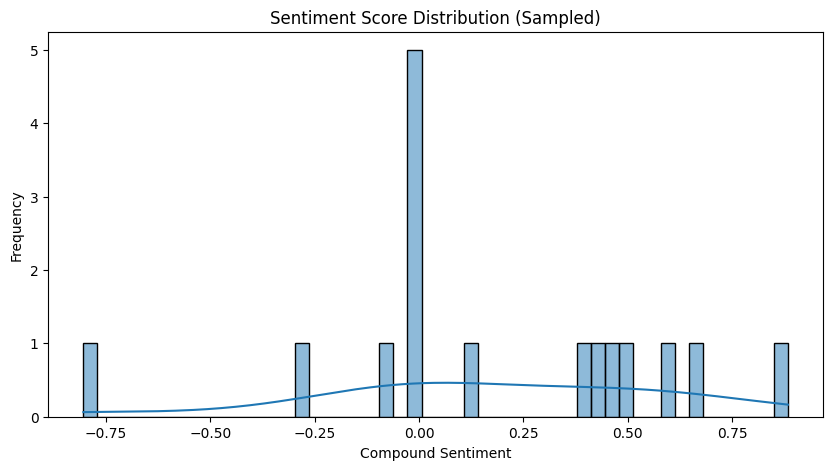

In [13]:
#Memory-Efficient Visualization

import matplotlib.pyplot as plt
import seaborn as sns

sample_df = df.sample(n=min(500, len(df)), random_state=42)

plt.figure(figsize=(10, 5))
sns.histplot(sample_df['sentiment'], bins=50, kde=True)
plt.title("Sentiment Score Distribution (Sampled)")
plt.xlabel("Compound Sentiment")
plt.ylabel("Frequency")
plt.show()


In [14]:
#Composite Signal Creation
import numpy as np

# Composite signal = sentiment + 0.5 * buy_signal - 0.5 * sell_signal
df['composite_signal'] = df['sentiment'] + 0.5 * df['buy_signal'] - 0.5 * df['sell_signal']

# Rolling mean + confidence interval (95%)
df['rolling_mean'] = df['composite_signal'].rolling(window=100, min_periods=10).mean()
df['rolling_std'] = df['composite_signal'].rolling(window=100, min_periods=10).std()
df['upper_bound'] = df['rolling_mean'] + 1.96 * df['rolling_std']
df['lower_bound'] = df['rolling_mean'] - 1.96 * df['rolling_std']

df[['composite_signal', 'rolling_mean', 'upper_bound', 'lower_bound']].tail()


,composite_signal,rolling_mean,upper_bound,lower_bound
11,-0.0772,0.178308,0.963148,-0.606532
12,0.5859,0.209662,0.993074,-0.573751
13,0.4939,0.229964,0.997229,-0.537300
14,-0.8037,0.161053,1.066749,-0.744643
15,0.0000,0.150987,1.029524,-0.727549


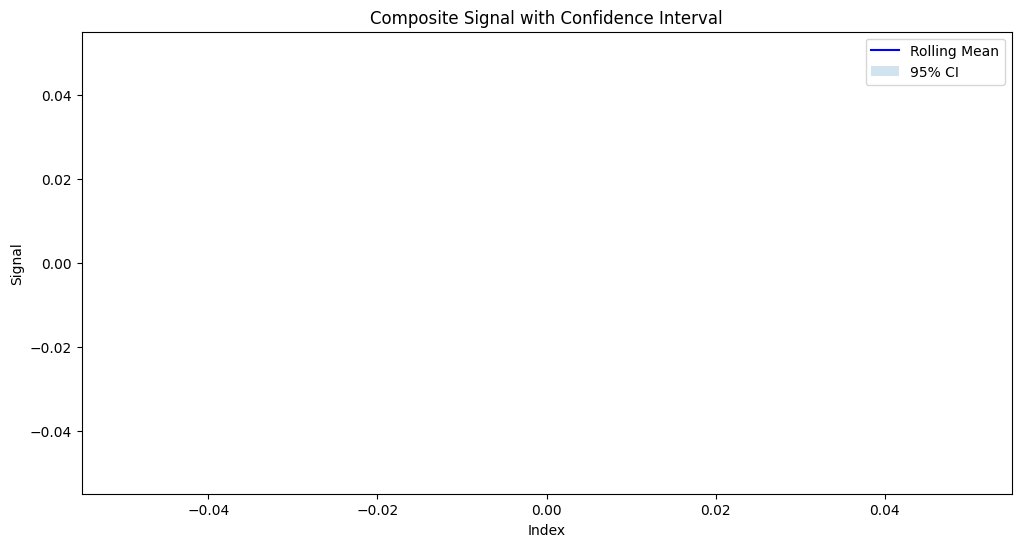

In [16]:
#Plot Composite Signal with Confidence Bands
plt.figure(figsize=(12, 6))
sample = df.dropna().iloc[-1000:]

plt.plot(sample['rolling_mean'], label="Rolling Mean", color='blue')
plt.fill_between(sample.index, sample['lower_bound'], sample['upper_bound'], alpha=0.2, label="95% CI")
plt.title("Composite Signal with Confidence Interval")
plt.xlabel("Index")
plt.ylabel("Signal")
plt.legend()
plt.show()
